## The collapse poset of a 2-dimensional simplicial set

The point of this notebook is to define a function which takes as input a 2-dimensional simplicial set $X$, and provides as output a poset whose vertices are simplicial sets obtained as collapses of $X$. The important point here is that, given a list of 2-simplices $\sigma_i$ of $X$, and a list of indices $j_i\in \{0,1\}$, it does not matter what order we collapse the simplices $\sigma_i$ in, so long as we always collapse $\sigma_i$ along the $j_i$-th face map. This means that the collapse poset will always be a subset of the $k$-cube $\mathcal{P}(X_2^{\operatorname{nd}}\times \{0,1\})$. Our first step will be to generate this cube from $X$. There are two ways of doing so: as a set, or as a lattice. 

In [1]:
from sage.topology.simplicial_set import AbstractSimplex, SimplicialSets

In [2]:
def collset(X):
    # Extract non-degenerate 2-simplices
    simps = X.n_cells(2)

    # Generate pairs of (simplex, i) where i is in {0, 1}
    X_collapses = Set(cartesian_product([simps, [0, 1]]))

    # Return a list of all subsets of these pairs
    return list(X_collapses.subsets())
    
def colllattice(X):
    # Extract non-degenerate 2-simplices
    simps = X.n_cells(2)

    # Generate pairs of (simplex, i) where i is in {0, 1}
    X_collapses = Set(cartesian_product([simps, [0, 1]]))

    # Return the lattice of all subsets of these pairs
    return X_collapses.subsets_lattice()

Example: the torus

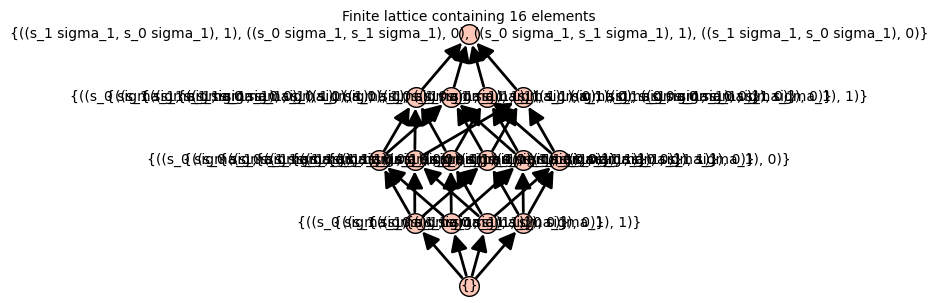

In [3]:
T = simplicial_sets.Torus()
Tlat = colllattice(T)
Tlat

Our next objective is to eliminate duplicates, by which I mean, restrict to those $\{(\sigma_1,j_1),\ldots,(\sigma_k,j_k)\}$ such that $\sigma_\ell= \sigma_r$ for $\ell\neq r$. 

In [4]:
def isduplicate(S):
    # Track seen simplices
    seen = set()

    # Check each simplex part for duplicates
    for simplicial_part in S:
        simplex = simplicial_part[0]
        if simplex in seen:
            return True
        seen.add(simplex)

    return False
    
def removeduplicates(L):
    return [item for item in L if not isduplicate(item)]

Example: the torus.

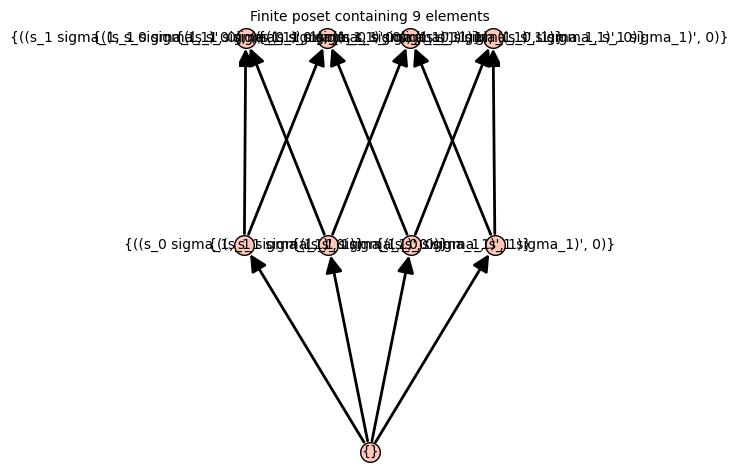

In [5]:
TND = removeduplicates(list(Tlat))
Tlat.subposet(TND)

We then need a function which implements a sequence of collapses specified by pairs $(\sigma,j)$ consisting of a simplex of $X$ and an index in $\{0,1\}$. We first define a function which implements a single collapse map. 

In [6]:
def collapse_simplex(X, sigma, i):
    # Create instances of the 2-simplex and the 1-simplex
    simp2 = simplicial_sets.Simplex(2)
    simp1 = simplicial_sets.Simplex(1)

    # Define the Homset from the 2-simplex to X
    H = Hom(simp2, X)
    # Choose the map which picks out sigma
    f1 = H({simp2.n_cells(2)[0]: sigma})

    # Define the Homset from delta2 to delta1
    G = Hom(simp2, simp1)
    # Specify the unique non-degenerate 1-simplex
    u01 = simp1.n_cells(1)[0]
    # Define the degeneracy map s_i
    s = G({simp2.n_cells(2)[0]: u01.apply_degeneracies(i)})

    # Compute the pushout against the degeneracy map s_i
    Y = simp2.pushout(f1, s)

    # Return the resulting simplicial set after the collapse
    return Y

We then iterate through these collapses to obtain the corresponding simplicial set. 

In [7]:
def collapseSimps(X, collapses):
    # Convert the enumerated set to a list for processing
    collapses = list(collapses)
    Y = X

    # Process each collapse in the list
    for i in range(len(collapses)):
        # Current collapse operation
        sigma, ind = collapses[i]

        # Perform the collapse on the current simplicial set Y
        Y = collapse_simplex(Y, sigma, ind)

        # If there are more collapses to process, update their simplices
        if i < len(collapses) - 1:
            # Update the structure map and apply it to the future collapses
            f = Y.structure_map(0)
            collapses[i+1:] = [(f(c[0]), c[1]) for c in collapses[i+1:]]

    # Return the modified simplicial set
    return Y


Example: we chose on element of the collapse poset of the torus, and obtain the corresponding simplicial set by collapse.

In [8]:
TND[6]

{((s_1 sigma_1, s_0 sigma_1), 1)}

In [9]:
Ttest = TND[6]
C3 = collapseSimps(T, Ttest)
C3.nondegenerate_simplices()

[(0,), (0, 1), (s_0 sigma_1, s_1 sigma_1)]

We next remove the 0-dimensional and 1-dimensional vertices. 

In [10]:
def removeLDim(X, collapses):
    return [collapse for collapse in collapses if collapseSimps(X, collapse).dimension() == 2]

In [11]:
TND

[{},
 {((s_0 sigma_1, s_1 sigma_1), 1)},
 {((s_1 sigma_1, s_0 sigma_1), 0)},
 {((s_0 sigma_1, s_1 sigma_1), 1), ((s_1 sigma_1, s_0 sigma_1), 0)},
 {((s_0 sigma_1, s_1 sigma_1), 0)},
 {((s_0 sigma_1, s_1 sigma_1), 0), ((s_1 sigma_1, s_0 sigma_1), 0)},
 {((s_1 sigma_1, s_0 sigma_1), 1)},
 {((s_1 sigma_1, s_0 sigma_1), 1), ((s_0 sigma_1, s_1 sigma_1), 1)},
 {((s_1 sigma_1, s_0 sigma_1), 1), ((s_0 sigma_1, s_1 sigma_1), 0)}]

In [12]:
TGD = removeLDim(T,TND)
TGD

[{},
 {((s_0 sigma_1, s_1 sigma_1), 1)},
 {((s_1 sigma_1, s_0 sigma_1), 0)},
 {((s_0 sigma_1, s_1 sigma_1), 0)},
 {((s_1 sigma_1, s_0 sigma_1), 1)}]

Finally, we develop code to test whether a given simplicial set is a wedge of the basic contextual pieces. 


In [13]:
### this function tests if a given simplex of a simplicial set is a basic contextual piece.
def is_basic_cont(X, sigma):
     # Check if at least two faces are equal and all are nondegenerate
    faces = X.faces(sigma)
    nondegenerate = all(face.is_nondegenerate() for face in faces)

    if nondegenerate:
        if faces[0] == faces[1] or faces[0] == faces[2] or faces[1] == faces[2]:
            return True

    return False

## this function tests if all 2-simplices of a simplicial set X are basic contextual pieces.
def all_basic_cont(X):
    # Check if all 2-simplices in X are basic contextual pieces
    return all(is_basic_cont(X, k) for k in X.n_cells(2))

In [14]:
all_basic_cont(T)

False

In [15]:
TGD[3]

{((s_0 sigma_1, s_1 sigma_1), 0)}

In [16]:
all_basic_cont(collapseSimps(T,TGD[4]))

False

We now can test the individual vertices of a scenario to see if they are basic contextual. We will apply this to the Mermin square (punctured torus) TODO: Insert Image

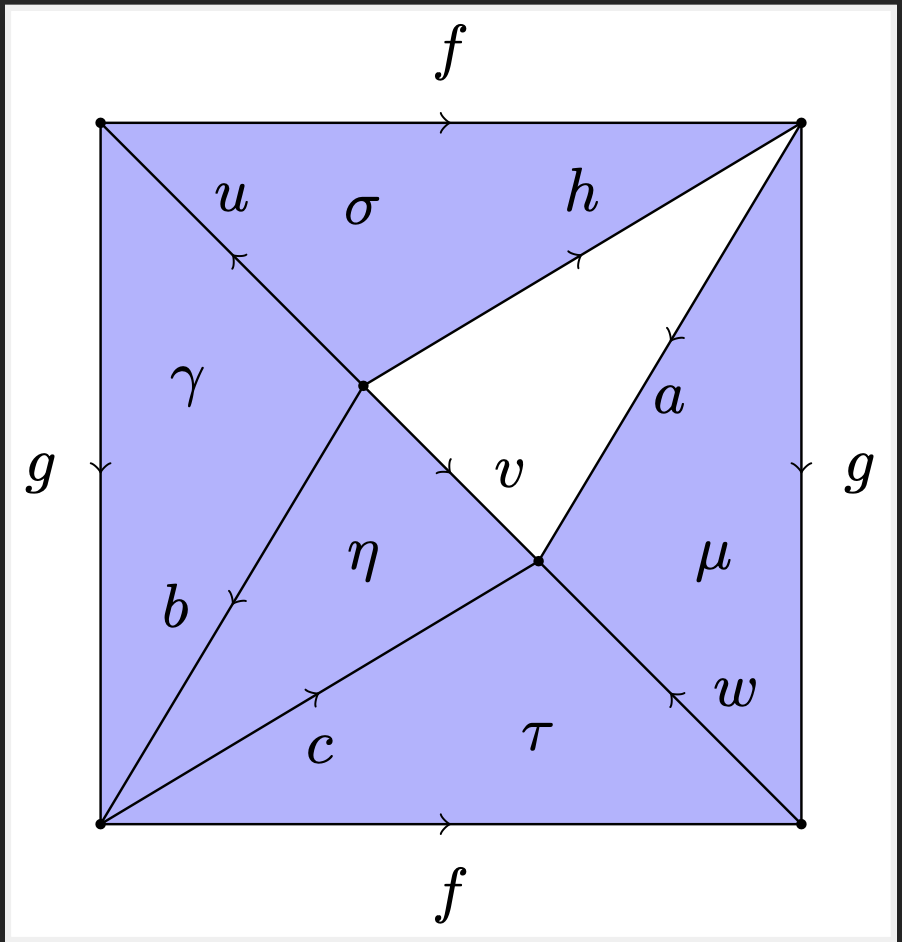


In [17]:
from sage.topology.simplicial_set import AbstractSimplex, SimplicialSet
sigma = AbstractSimplex(2,name='sigma')
gamma = AbstractSimplex(2,name='gamma')
eta = AbstractSimplex(2,name='eta')
tau = AbstractSimplex(2,name='tau')
mu = AbstractSimplex(2,name='mu')

f = AbstractSimplex(1,name='f')
g = AbstractSimplex(1,name='g')
h = AbstractSimplex(1,name='h')
u = AbstractSimplex(1,name='u')
v = AbstractSimplex(1,name='v')
w = AbstractSimplex(1,name='w')
a = AbstractSimplex(1,name='a')
b = AbstractSimplex(1,name='b')
c = AbstractSimplex(1,name='c')

x = AbstractSimplex(0,name='x')
y = AbstractSimplex(0,name='y')
z = AbstractSimplex(0,name='z')


punctured_mermin = SimplicialSet({sigma:(f,h,u),
                      gamma:(g,b,u),
                      eta:(c,v,b),
                      tau:(w,c,f),
                      mu:(w,a,g),
                      f:(x,x),
                      h:(x,y),
                      u:(x,y),
                      g:(x,x),
                      a:(z,x),
                      v:(z,y),
                      c:(z,x),
                      b:(x,y),
                      w:(z,x)})

double_punctured_mermin = SimplicialSet({sigma:(f,h,u),
                      gamma:(g,b,u),
                      tau:(w,c,f),
                      mu:(w,a,g),
                      f:(x,x),
                      h:(x,y),
                      u:(x,y),
                      g:(x,x),
                      a:(z,x),
                      c:(z,x),
                      b:(x,y),
                      w:(z,x)})

example_1 = SimplicialSet(data={sigma: (f,h,u),
                      tau: (g,h,u),
                      f:(z,y),
                      g:(z,y),
                      h:(z,x),
                      u:(y,x)})

example_2 = SimplicialSet(data={sigma: (f,b,u),
                      tau: (g,h,u),
                      eta: (b,h,v),
                      f:(z,y),
                      u:(y,x),
                      g:(z,y),
                      h:(z,x),
                      v:(x,x),
                      b:(z,x)})

As a check to ensure I've entered the Mermin square correctly, I compute the homology (which should be that of the wedge of two circles). 

In [18]:
punctured_mermin.homology()

{0: 0, 1: Z x Z, 2: 0}

In [19]:
double_punctured_mermin.homology()

{0: 0, 1: Z x Z, 2: 0}

In [20]:
def find_maximal_elements(X):
    # Initialize a list to store maximal elements
    maximal_elements = []
    
    for element in X:
        # Assume the element is maximal until proven otherwise
        is_maximal = True

        # Compare with other elements and if it is a subset of another element then it is not maximal.
        for other_element in X:
            if element != other_element and element.issubset(other_element):
                is_maximal = False
                break
                
        # If the element is maximal, add it to the list
        if is_maximal:
            maximal_elements.append(element)

    return maximal_elements

In [21]:
def get_collapse_list(X):
    # Define the coarse lattice of possible collapses
    collapse_lattice = colllattice(X)
    
    # Convert the poset into a list and remove duplicates because these collapses cannot be realized 
    # since it collapses the same simplex twice.
    collapse_list = removeduplicates(list(collapse_lattice))
    
    # Remove elements which result in a simplicial set with dimension less than 2.
    collapse_list = removeLDim(X, collapse_list)
    
    # Find maximal elements, which represent minimal non-trivial collapses
    # (in the sense that everything except one two-simplex has been collapsed)
    collapse_list = find_maximal_elements(collapse_list)

    return collapse_list

In [22]:
punctured_mermin_collapse_list = get_collapse_list(punctured_mermin)

In [23]:
example_collapse = punctured_mermin_collapse_list[0]
print(example_collapse)

{(gamma, 0), (sigma, 0), (eta, 1), (mu, 0)}


In [24]:
collapseSimps(punctured_mermin, example_collapse)

Pushout of maps:
  Simplicial set morphism:
    From: 2-simplex
    To:   Pushout of maps:
    Simplicial set morphism:
      From: 2-simplex
      To:   Pushout of maps:
      Simplicial set morphism:
        From: 2-simplex
        To:   Pushout of maps:
        Simplicial set morphism:
          From: 2-simplex
          To:   Simplicial set with 17 non-degenerate simplices
          Defn: [(0,), (1,), (2,), (0, 1), (0, 2), (1, 2), (0, 1, 2)] --> [y, x, x, u, b, g, gamma]
        Simplicial set morphism:
          From: 2-simplex
          To:   1-simplex
          Defn: [(0,), (1,), (2,), (0, 1), (0, 2), (1, 2), (0, 1, 2)] --> [(0,), (0,), (1,), s_0 (0,), (0, 1), (0, 1), s_0 (0, 1)]
        Defn: [(0,), (1,), (2,), (0, 1), (0, 2), (1, 2), (0, 1, 2)] --> [(0,), (0,), (0,), s_0 (0,), h, f, sigma]
      Simplicial set morphism:
        From: 2-simplex
        To:   1-simplex
        Defn: [(0,), (1,), (2,), (0, 1), (0, 2), (1, 2), (0, 1, 2)] --> [(0,), (0,), (1,), s_0 (0,), (0, 1), (0

In [25]:
def has_contextual_collapse(X):
    """
    Check if the simplicial set X has a contextual collapse.
    A contextual collapse is one where all 2-simplices in the resulting 
    simplicial set are basic contextual pieces.
    """
    
    # Generate a list of potential collapses for X
    collapse_list = get_collapse_list(X)

    # Check each potential collapse
    for collapse in collapse_list:
        # Apply the collapse and check if all 2-simplices are basic contextual pieces
        if all_basic_cont(collapseSimps(X, collapse)):
            return True

    # If no suitable collapse is found, return False
    return False

In [26]:
has_contextual_collapse(punctured_mermin)

False

In [27]:
has_contextual_collapse(double_punctured_mermin)

False

In [28]:
has_contextual_collapse(example_1)

True

In [29]:
has_contextual_collapse(example_2)

True